In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

## Problem Overview
You work for an airline in the pricing department, and you want to find the optimal pricing policy and number of tickets to offer for sale on a particular flight to maximize expected discounted profit ( = revenue of ticket sales - <u>*overbooking*</u> costs); we’ll consider other costs to be fixed. Revenue comes in from demand for tickets in the time before takeoff, where you will decide the optimal price to charge each day. Overbooking costs come in when more people show up for the flight than there are seats on the plane, if the flight is overbooked. In that case you must pay a stipend to the passengers who cannot get on the plane.

The flight you’re analyzing has two ticket classes, coach and first-class. Your manager is not willing to allow overbooking in first-class but is open to the idea of overbooking coach. In the case that more people show up with tickets for coach than there are seats available in coach, you can bump ticket holders up to first-class if there are seats available in first-class. Everyone that gets bumped up to first-class from coach imposes an overbooking cost to the airline, and everyone that does not get a seat on the flight imposes a greater overbooking cost to the airline.

When selling tickets in coach there are two possible ticket prices, each leading to different demand distributions, and there are two possible ticket prices for first-class, again leading to different demand distributions. <u>Assume that demand for coach and first-class seats are independent.</u> On each day there will be either 0 or 1 ticket sold in coach and 0 or 1 ticket sold in first-class. The probability of a sale for each ticket class depends on the price of the ticket; just like in the example in class. If there is more demand for first-class than there are seats in first-class, customers won’t buy a coach seat. If there is more demand for coach seats than allowed by the overbooking policy, customers won’t buy a first-class seat. However, to account for the people who would usually book a first-class seat but can’t, when first-class is sold out, the chance of a sale in coach increases by 3% points, regardless of the coach ticket price.

Find the optimal pricing policy using dynamic programming. Solve this problem for several overbooking policies and find the policy with the largest expected discounted profit.

## Q1
Assume there are 365 days until the plane departs (you have 365 opportunities to sell tickets), after that people either show up or not to the flight. 

100 seats in coach and 20 seats in first-class. Each coach ticket holder shows up to the flight with probability 95%, and each first-class ticket holder shows up to the flight with probability 97%. 

\\$300 or \\$350 for coach; \\$425 or \\$500 for first-class 

> \\$300 for coach $\longrightarrow$ 65% chance a coach ticket is sold; \\$350 for coach $\longrightarrow$ 30% chance a coach ticket is sold\
> \\$425 for first-class $\longrightarrow$ 8% chance a first-class ticket is sold, \\$500 for first-class $\longrightarrow$ 4% chance a first-class ticket is sold. 

For the first iteration, examine the expected discounted revenue when you allow coach to be oversold by 5 seats. It costs \\$50 to bump a coach passenger to first-class and it costs \\$425 to bump a coach passenger off the plane. 

Discount rate = 17%, daily discount factor = 1/(1+0.17/365).

What is the expected discounted profit of selling these tickets and paying out overbooking costs over the course of the year?

1. On the day the flight takes off there is no revenue, only costs. You can calculate the expected cost using the binomial distribution (`scipy.stats.binom.pmf`), where the number of trials is the number of tickets sold, and a success is if a passenger shows up for the flight.

2. When first-class sold out, if coach = \\$300, chance 65% $\rightarrow$ 68%; if coach = \\$350, chance 30% $\rightarrow$ 33%.

state variables: $t,c,f$ (time, coach class tickets sold, and first class tickets sold)

decision variables: HH, HL, LH, LL (sell high/low for coach class, and sell high/low for first class)

terminal/boundary: 
$$V(c,f,T)=-\sum_{i=0}^c \sum_{j=0}^f Pr(i)Pr(j)cost(i,j)$$ 
where $Pr(i)$ is the probability that $i$ customers show up among $c$ coach class tickets sold, similar for $Pr(j)$

Bellman:
$$V(c,f,t)=\max_{p_c,p_f}\mathbb{E}[rev_t+\delta V(c,f,t+1)]$$
$$=\max [\mathbb{E}(rev_t+\delta V(c,f,t+1))(HH), \mathbb{E}(rev_t+\delta V(c,f,t+1))(HL),\mathbb{E}(rev_t+\delta V(c,f,t+1))(LH),\mathbb{E}(rev_t+\delta V(c,f,t+1))(LL)]$$

where, for example, HH, $$\mathbb{E}(rev_t+\delta V(c,f,t+1)) = $$ $$rev(s,s)Pr(s,s)+rev(s,ns)Pr(s,ns)+rev(ns,s)Pr(ns,s)+rev(ns,ns)Pr(ns,ns) + $$ $$V(c+1,f+1,t+1)Pr(s,s)+V(c+1,f,t+1)Pr(s,ns)+V(c,f+1,t+1)Pr(ns,s)+V(c,f,t+1)Pr(ns,ns)$$

In [2]:
# define all related variables
T = 365
rate = 0.17
delta = 1/(1+rate/T)
p_coachshow, p_firstshow = 0.95, 0.97
coach, first = 100, 20

priceLcoach, priceHcoach = 300, 350
priceLfirst, priceHfirst = 425, 500
bump_first, bump_off = 50, 425

overbook = 5

prLf = [0.08, 0.92]
prHf = [0.04, 0.96]
prLc = [0.65, 0.35]
prHc = [0.3, 0.7]

# prob of coach sale when first class is sold out
prLc_ = [0.68, 0.32]
prHc_ = [0.33, 0.67]

In [3]:
# all possible states of coach class sold and first class sold
coachValues = np.arange(coach + overbook + 1)
firstValues = np.arange(first+1)

# all time states
tValues = np.arange(T+1)

tN, cN, fN = len(tValues), len(coachValues), len(firstValues)
print(tN,cN,fN)

366 106 21


In [4]:
V = np.zeros((cN,fN,tN)) # value array
U = np.zeros((cN,fN,tN)) # decision array

In [5]:
# boundary/terminal
for c in coachValues:
    for f in firstValues:
        if c > coach:
            cost = 0
            for i in range(coach+1, c+1): # 101 to whatever c is (how many coach class showed up)
                for j in range(f+1): # 0 to f (how many first class showed up)
                    coach_over = i-coach  # with i coach class showed up, how many we need to bump
                    first_left = first-j  # with j first class showed up, how many first class seats are left
                    prc_show = binom.pmf(i,c,p_coachshow) # among c tickets sold, prob of i coach class show up
                    prf_show = binom.pmf(j,f,p_firstshow) # among f tickets sold, prob of j first class show up
                    if coach_over <= first_left:
        # no matter how many first show up, we can bump overbook to first 
                        cost += bump_first*coach_over * prc_show * prf_show
                    else: 
        # if first class show-up is less than overbook, we can bump all to first; otherwise bump some off plane
                        bump_to_first = (bump_first*first_left) * prc_show * prf_show
                        bump_off_plane = bump_off*(coach_over-first_left) * prc_show * prf_show
                        cost += (bump_to_first + bump_off_plane)
            V[c,f,T] = -cost

In [6]:
# bellman
# decision: H/L for coach, H/L for first
# 0-HH, 1-HL, 2-LH, 3-LL, 4-no sale
for t in reversed(range(tN-1)):
    for c in range(cN):
        for f in range(fN):
            if c == (coach+overbook) and f == first: 
                # both coach and first class are sold out, no sale can be made
                V[c,f,t] = delta*V[c,f,t+1]
                U[c,f,t] = 4
            elif c == (coach+overbook) and f < first: # coach is sold out, only consider first class sales
## revenue made today = expected revenue today (high/low) + discounted expected revenue tmr (high/low)
                rev_today_H = priceHfirst*prHf[0]
                rev_tmr_H = V[c,f+1,t+1]*prHf[0] + V[c,f,t+1]*prHf[1]
                valueH = rev_today_H + delta * rev_tmr_H
                
                rev_today_L = priceLfirst*prLf[0]
                rev_tmr_L = V[c,f+1,t+1]*prLf[0] + V[c,f,t+1]*prLf[1]
                valueL = rev_today_L + delta * rev_tmr_L
                
                V[c,f,t] = max(valueH, valueL)
                U[c,f,t] = np.argmax([valueH, valueL]) 
                # choice is either HH or HL (coach class decision doesn't matter here)
            elif f == first and c < (coach+overbook): # first is sold out, only consider coach class sale
## revenue made today = expected revenue today (high/low) + discounted expected revenue tmr (high/low)
                rev_today_H = priceHcoach*prHc_[0]
                rev_tmr_H = V[c+1,f,t+1]*prHc_[0] + V[c,f,t+1]*prHc_[1]
                valueH = rev_today_H + delta * rev_tmr_H
                
                rev_today_L = priceLcoach*prLc_[0]
                rev_tmr_L = V[c+1,f,t+1]*prLc_[0] + V[c,f,t+1]*prLc_[1]
                valueL = rev_today_L + delta * rev_tmr_L
                
                V[c,f,t] = max(valueH, valueL)
                U[c,f,t] = np.argmax([valueH, valueL]) * 2  
                # choice is either 0-HH, or 2-LH (first class decision doesn't matter here)
            else:                
                # High price in coach class, High price in first class
                rev_today_HH = (priceHcoach+priceHfirst)*prHc[0]*prHf[0] + \
                                priceHcoach*prHc[0]*prHf[1] + priceHfirst*prHc[1]*prHf[0] + 0
                rev_tmr_HH = V[c+1,f+1,t+1]*prHc[0]*prHf[0] + V[c+1,f,t+1]*prHc[0]*prHf[1] + \
                             V[c,f+1,t+1]*prHc[1]*prHf[0]   + V[c,f,t+1]*prHc[1]*prHf[1]
                valueHH = rev_today_HH + delta * rev_tmr_HH
                
                # High price in coach class, Low price in first class
                rev_today_HL = (priceHcoach+priceLfirst)*prHc[0]*prLf[0] + \
                                priceHcoach*prHc[0]*prLf[1] + priceLfirst*prHc[1]*prLf[0] + 0
                rev_tmr_HL = V[c+1,f+1,t+1]*prHc[0]*prLf[0] + V[c+1,f,t+1]*prHc[0]*prLf[1] + \
                             V[c,f+1,t+1]*prHc[1]*prLf[0]   + V[c,f,t+1]*prHc[1]*prLf[1]
                valueHL = rev_today_HL + delta * rev_tmr_HL
                
                # Low price in coach class, High price in first class
                rev_today_LH = (priceLcoach+priceHfirst)*prLc[0]*prHf[0] + \
                                priceLcoach*prLc[0]*prHf[1] + priceHfirst*prLc[1]*prHf[0] + 0
                rev_tmr_LH = V[c+1,f+1,t+1]*prLc[0]*prHf[0] + V[c+1,f,t+1]*prLc[0]*prHf[1] + \
                             V[c,f+1,t+1]*prLc[1]*prHf[0]   + V[c,f,t+1]*prLc[1]*prHf[1]
                valueLH = rev_today_LH + delta * rev_tmr_LH
                
                # Low price in coach class, Low price in first class
                rev_today_LL = (priceLcoach+priceLfirst)*prLc[0]*prLf[0] + \
                                priceLcoach*prLc[0]*prLf[1] + priceLfirst*prLc[1]*prLf[0] + 0
                rev_tmr_LL = V[c+1,f+1,t+1]*prLc[0]*prLf[0] + V[c+1,f,t+1]*prLc[0]*prLf[1] + \
                             V[c,f+1,t+1]*prLc[1]*prLf[0]   + V[c,f,t+1]*prLc[1]*prLf[1]
                valueLL = rev_today_LL + delta * rev_tmr_LL
                
                V[c,f,t] = max(valueHH, valueHL, valueLH, valueLL)
                U[c,f,t] = np.argmax([valueHH, valueHL, valueLH, valueLL]) 

In [7]:
# expected profit looking from day 1, when no sale is made and time = 0
V[0,0,0]

41886.15862419571

## Q2
Repeat step (1) while allowing coach to be oversold by 6, 7, 8, ..., 15 seats. Which overbooking policy from this leads to the largest profits by the airline?

In [8]:
## define a function for this dynamic programming with the parameter being coaches that can be oversold
def dynamic(overbook):
    coachValues = np.arange(coach + overbook + 1)
    firstValues = np.arange(first+1)
    tValues = np.arange(T+1)

    tN, cN, fN = len(tValues), len(coachValues), len(firstValues)
    
    V = np.zeros((cN,fN,tN))
    U = np.zeros((cN,fN,tN))
    
    # boundary/terminal
    for c in coachValues:
        for f in firstValues:
            if c > coach:
                cost = 0
                for i in range(coach+1, c+1): # 101 to whatever c is (how many coach class showed up)
                    for j in range(f+1): # 0 to f (how many first class showed up)
                        coach_over = i-coach  # with i coach class showed up, how many we need to bump
                        first_left = first-j  # with j first class showed up, how many first class seats are left
                        prc_show = binom.pmf(i,c,p_coachshow) # among c sold, prob of i coach ppl show up
                        prf_show = binom.pmf(j,f,p_firstshow) # among f sold, prob of j first ppl show up
                        if coach_over <= first_left:  
                        # we can always bump overbook to first 
                            cost += bump_first*coach_over * prc_show * prf_show
                        else: 
                        # if first class show-up is less than overbook, we can bump all to first; 
                        # otherwise bump some off plane
                            bump_to_first = (bump_first*first_left) * prc_show * prf_show
                            bump_off_plane = bump_off*(coach_over-first_left) * prc_show * prf_show
                            cost += (bump_to_first + bump_off_plane)
                V[c,f,T] = -cost
                
    # bellman
    # decision: H/L for coach, H/L for first
    # 0-HH, 1-HL, 2-LH, 3-LL, 4-no sale
    for t in reversed(range(tN-1)):
        for c in range(cN):
            for f in range(fN):
                if c == (coach+overbook) and f == first: 
                    # both coach and first class are sold out, no sale can be made
                    V[c,f,t] = delta*V[c,f,t+1]
                    U[c,f,t] = 4
                elif c == (coach+overbook) and f < first: # coach is sold out, only consider first class sales
    ## revenue made today = expected revenue today (high/low) + discounted expected revenue tmr (high/low)
                    rev_today_H = priceHfirst*prHf[0]
                    rev_tmr_H = V[c,f+1,t+1]*prHf[0] + V[c,f,t+1]*prHf[1]
                    valueH = rev_today_H + delta * rev_tmr_H

                    rev_today_L = priceLfirst*prLf[0]
                    rev_tmr_L = V[c,f+1,t+1]*prLf[0] + V[c,f,t+1]*prLf[1]
                    valueL = rev_today_L + delta * rev_tmr_L

                    V[c,f,t] = max(valueH, valueL)
                    U[c,f,t] = np.argmax([valueH, valueL]) 
                    # choice is either HH or HL (coach class decision doesn't matter here)
                elif f == first and c < (coach+overbook): # first is sold out, only consider coach class sale
    ## revenue made today = expected revenue today (high/low) + discounted expected revenue tmr (high/low)
                    rev_today_H = priceHcoach*prHc_[0]
                    rev_tmr_H = V[c+1,f,t+1]*prHc_[0] + V[c,f,t+1]*prHc_[1]
                    valueH = rev_today_H + delta * rev_tmr_H

                    rev_today_L = priceLcoach*prLc_[0]
                    rev_tmr_L = V[c+1,f,t+1]*prLc_[0] + V[c,f,t+1]*prLc_[1]
                    valueL = rev_today_L + delta * rev_tmr_L

                    V[c,f,t] = max(valueH, valueL)
                    U[c,f,t] = np.argmax([valueH, valueL]) * 2  
                    # choice is either 0-HH, or 2-LH (first class decision doesn't matter here)
                else:                
                    # High price in coach class, High price in first class
                    rev_today_HH = (priceHcoach+priceHfirst)*prHc[0]*prHf[0] + \
                                    priceHcoach*prHc[0]*prHf[1] + priceHfirst*prHc[1]*prHf[0] + 0
                    rev_tmr_HH = V[c+1,f+1,t+1]*prHc[0]*prHf[0] + V[c+1,f,t+1]*prHc[0]*prHf[1] + \
                                 V[c,f+1,t+1]*prHc[1]*prHf[0]   + V[c,f,t+1]*prHc[1]*prHf[1]
                    valueHH = rev_today_HH + delta * rev_tmr_HH

                    # High price in coach class, Low price in first class
                    rev_today_HL = (priceHcoach+priceLfirst)*prHc[0]*prLf[0] + \
                                    priceHcoach*prHc[0]*prLf[1] + priceLfirst*prHc[1]*prLf[0] + 0
                    rev_tmr_HL = V[c+1,f+1,t+1]*prHc[0]*prLf[0] + V[c+1,f,t+1]*prHc[0]*prLf[1] + \
                                 V[c,f+1,t+1]*prHc[1]*prLf[0]   + V[c,f,t+1]*prHc[1]*prLf[1]
                    valueHL = rev_today_HL + delta * rev_tmr_HL

                    # Low price in coach class, High price in first class
                    rev_today_LH = (priceLcoach+priceHfirst)*prLc[0]*prHf[0] + \
                                    priceLcoach*prLc[0]*prHf[1] + priceHfirst*prLc[1]*prHf[0] + 0
                    rev_tmr_LH = V[c+1,f+1,t+1]*prLc[0]*prHf[0] + V[c+1,f,t+1]*prLc[0]*prHf[1] + \
                                 V[c,f+1,t+1]*prLc[1]*prHf[0]   + V[c,f,t+1]*prLc[1]*prHf[1]
                    valueLH = rev_today_LH + delta * rev_tmr_LH

                    # Low price in coach class, Low price in first class
                    rev_today_LL = (priceLcoach+priceLfirst)*prLc[0]*prLf[0] + \
                                    priceLcoach*prLc[0]*prLf[1] + priceLfirst*prLc[1]*prLf[0] + 0
                    rev_tmr_LL = V[c+1,f+1,t+1]*prLc[0]*prLf[0] + V[c+1,f,t+1]*prLc[0]*prLf[1] + \
                                 V[c,f+1,t+1]*prLc[1]*prLf[0]   + V[c,f,t+1]*prLc[1]*prLf[1]
                    valueLL = rev_today_LL + delta * rev_tmr_LL

                    V[c,f,t] = max(valueHH, valueHL, valueLH, valueLL)
                    U[c,f,t] = np.argmax([valueHH, valueHL, valueLH, valueLL]) 
    return V,U

In [9]:
policy = {'overbook':[], 'profit':[]} # dictionary for each overbooking policy and profits expected
for i in range(5,16):
    V,U = dynamic(i)
    profit = V[0,0,0]
    policy['overbook'].append(i)
    policy['profit'].append(profit)
    print('{} overbook, optimal profit ${:.2f}'.format(i, profit))

5 overbook, optimal profit $41886.16
6 overbook, optimal profit $42011.22
7 overbook, optimal profit $42085.54
8 overbook, optimal profit $42122.17
9 overbook, optimal profit $42134.62
10 overbook, optimal profit $42132.90
11 overbook, optimal profit $42123.67
12 overbook, optimal profit $42111.03
13 overbook, optimal profit $42097.42
14 overbook, optimal profit $42084.11
15 overbook, optimal profit $42071.74


In [33]:
df = pd.DataFrame.from_dict(policy)

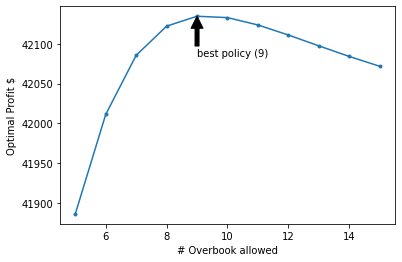

In [35]:
plt.plot(df.overbook, df.profit, marker='.')
max_p = df.profit.max()
max_over = df[df.profit == max_p]['overbook']
plt.annotate('best policy ({})'.format(int(max_over)), \
             xy=(max_over, max_p), xytext=(max_over, max_p-50),\
             arrowprops=dict(facecolor='black'))
plt.xlabel('# Overbook allowed')
plt.ylabel('Optimal Profit $');

In the given choices, the best overbooking policy is to allow 9 oversales in the coach class. The expected profit is \\$42134.62

## Q3
Consider a new policy that allows the airline to choose to sell no coach tickets on a day if it wants; the airline has the option to force demand to 0 on a day. Now there are 3 choices each day for coach: high price, low price, and no sale. There are still just 2 choices each day for first class (H/L). Assume that the airline will never sell more than 120 seats in coach, but on any one day they can choose to not sell coach tickets. This way they can stop over-selling tickets not just based on how many they have sold, but also on how many days are left to sell. Does this policy have a better or worse expected profit than the best policy from step 2?

state variables and boundary/terminal conditions are the same

decision variables: HH, HL, LH, LL, XH, XL (X for not selling)

In [26]:
## define a function for this dynamic programming with the parameter being coaches that can be oversold
def dynamic_allow_nosale(overbook):
    coachValues = np.arange(coach + overbook + 1)
    firstValues = np.arange(first+1)
    tValues = np.arange(T+1)

    tN, cN, fN = len(tValues), len(coachValues), len(firstValues)
    V = np.zeros((cN,fN,tN))
    U = np.zeros((cN,fN,tN))
    
    # boundary/terminal (this is the same as question 1 and 2)
    for c in coachValues:
        for f in firstValues:
            if c > coach:
                cost = 0
                for i in range(coach+1, c+1): # 101 to whatever c is (how many coach class showed up)
                    for j in range(f+1): # 0 to f (how many first class showed up)
                        coach_over = i-coach  # with i coach class showed up, how many we need to bump
                        first_left = first-j  # with j first class showed up, how many first class seats are left
                        prc_show = binom.pmf(i,c,p_coachshow) # among c sold, prob of i coach ppl show up
                        prf_show = binom.pmf(j,f,p_firstshow) # among f sold, prob of j first ppl show up
                        if coach_over <= first_left:  
                        # we can always bump overbook to first 
                            cost += bump_first*coach_over * prc_show * prf_show
                        else: 
                        # if first class show-up is less than overbook, we can bump all to first; 
                        # otherwise bump some off plane
                            bump_to_first = (bump_first*first_left) * prc_show * prf_show
                            bump_off_plane = bump_off*(coach_over-first_left) * prc_show * prf_show
                            cost += (bump_to_first + bump_off_plane)
                V[c,f,T] = -cost
                
    # bellman
    # decision: H/L/X for coach, H/L for first
    # 0-HH, 1-HL, 2-LH, 3-LL, 4-XH, 5-XL, 6-XX
    for t in reversed(range(tN-1)):
        for c in range(cN):
            for f in range(fN):
                if c == (coach+overbook) and f == first:
                    V[c,f,t] = delta*V[c,f,t+1]
                    U[c,f,t] = 6
                elif c == (coach+overbook) and f < first:
                    # coach is full, only consider first class sales
                    rev_today_H = priceHfirst*prHf[0]
                    rev_tmr_H = V[c,f+1,t+1]*prHf[0] + V[c,f,t+1]*prHf[1]
                    valueH = rev_today_H + delta * rev_tmr_H

                    rev_today_L = priceLfirst*prLf[0]
                    rev_tmr_L = V[c,f+1,t+1]*prLf[0] + V[c,f,t+1]*prLf[1]
                    valueL = rev_today_L + delta * rev_tmr_L

                    V[c,f,t] = max(valueH, valueL)
                    U[c,f,t] = np.argmax([valueH, valueL])
                    # choice is either HH or HL (coach class decision doesn't matter here)
                elif f == first and c < (coach+overbook):
                    # first is full, only consider coach class sales
                    rev_today_H = priceHcoach*prHc_[0]
                    rev_tmr_H = V[c+1,f,t+1]*prHc_[0] + V[c,f,t+1]*prHc_[1]
                    valueH = rev_today_H + delta * rev_tmr_H

                    rev_today_L = priceLcoach*prLc_[0]
                    rev_tmr_L = V[c+1,f,t+1]*prLc_[0] + V[c,f,t+1]*prLc_[1]
                    valueL = rev_today_L + delta * rev_tmr_L

                    # profit today if no sale = 0
                    # profit tmr if no sale = V[c,f,t+1], 100%
                    valueX = delta * V[c,f,t+1]

                    V[c,f,t] = max(valueH, valueL, valueX)
                    U[c,f,t] = np.argmax([valueH, valueL, valueX]) * 2  
                    # choice is either HH, LH, or XH (first class decision doesn't matter here)
                else:                
                    # High price in coach class, High price in first class
                    rev_today_HH = (priceHcoach+priceHfirst)*prHc[0]*prHf[0] + \
                                    priceHcoach*prHc[0]*prHf[1] + priceHfirst*prHc[1]*prHf[0] + 0
                    rev_tmr_HH = V[c+1,f+1,t+1]*prHc[0]*prHf[0] + V[c+1,f,t+1]*prHc[0]*prHf[1] + \
                                 V[c,f+1,t+1]*prHc[1]*prHf[0]   + V[c,f,t+1]*prHc[1]*prHf[1]
                    valueHH = rev_today_HH + delta * rev_tmr_HH

                    # High price in coach class, Low price in first class
                    rev_today_HL = (priceHcoach+priceLfirst)*prHc[0]*prLf[0] + \
                                    priceHcoach*prHc[0]*prLf[1] + priceLfirst*prHc[1]*prLf[0] + 0
                    rev_tmr_HL = V[c+1,f+1,t+1]*prHc[0]*prLf[0] + V[c+1,f,t+1]*prHc[0]*prLf[1] + \
                                 V[c,f+1,t+1]*prHc[1]*prLf[0]   + V[c,f,t+1]*prHc[1]*prLf[1]
                    valueHL = rev_today_HL + delta * rev_tmr_HL

                    # Low price in coach class, High price in first class
                    rev_today_LH = (priceLcoach+priceHfirst)*prLc[0]*prHf[0] + \
                                    priceLcoach*prLc[0]*prHf[1] + priceHfirst*prLc[1]*prHf[0] + 0
                    rev_tmr_LH = V[c+1,f+1,t+1]*prLc[0]*prHf[0] + V[c+1,f,t+1]*prLc[0]*prHf[1] + \
                                 V[c,f+1,t+1]*prLc[1]*prHf[0]   + V[c,f,t+1]*prLc[1]*prHf[1]
                    valueLH = rev_today_LH + delta * rev_tmr_LH

                    # Low price in coach class, Low price in first class
                    rev_today_LL = (priceLcoach+priceLfirst)*prLc[0]*prLf[0] + \
                                    priceLcoach*prLc[0]*prLf[1] + priceLfirst*prLc[1]*prLf[0] + 0
                    rev_tmr_LL = V[c+1,f+1,t+1]*prLc[0]*prLf[0] + V[c+1,f,t+1]*prLc[0]*prLf[1] + \
                                 V[c,f+1,t+1]*prLc[1]*prLf[0]   + V[c,f,t+1]*prLc[1]*prLf[1]
                    valueLL = rev_today_LL + delta * rev_tmr_LL

                    # No sale in coach class, High price in first class
                    rev_today_XH = priceHfirst*prHf[0]  # the only possible profit comes from sell first in H
                    rev_tmr_XH = V[c,f+1,t+1]*prHf[0] + V[c,f,t+1]*prHf[1]
                    valueXH = rev_today_XH + delta * rev_tmr_XH

                    # No sale in coach class, Low price in first class
                    rev_today_XL = priceLfirst*prLf[0]
                    rev_tmr_XL = V[c,f+1,t+1]*prLf[0] + V[c,f,t+1]*prLf[1]
                    valueXL = rev_today_XL + delta * rev_tmr_XL

                    V[c,f,t] = max(valueHH, valueHL, valueLH, valueLL, valueXH, valueXL)
                    U[c,f,t] = np.argmax([valueHH, valueHL, valueLH, valueLL, valueXH, valueXL])
    return V,U

In [27]:
seat = 120
V,U = dynamic_allow_nosale(seat-coach)
V[0,0,0]

42139.89276231963

In [28]:
# compare the two policies with 20 oversales allowed
V_nosale, _ = dynamic_allow_nosale(seat-coach)
V_sale, _ = dynamic(seat-coach)
print('With the choice of no sale, profit is $', round(V_nosale[0,0,0],2))
print('With the original policy, profit is $', round(V_sale[0,0,0],2))

With the choice of no sale, profit is $ 42139.89
With the original policy, profit is $ 42028.74


In [36]:
nosale_profits = []
df_idx = 11
for i in range(5,21):
    V,_ = dynamic_allow_nosale(i)
    if i > 15:  # in Q2 we only checked options of 5-15 oversales
        V_opt1,_ = dynamic(i)
        df.loc[df_idx] = [i,V_opt1[0,0,0]]
        df_idx += 1
    profit_nosale = V[0,0,0]
    nosale_profits.append(profit_nosale)

In [37]:
df['profit_allow_nosale'] = pd.Series(nosale_profits)
df

,overbook,profit,profit_allow_nosale
0,5.0,41886.158624,41886.158624
1,6.0,42011.221060,42011.221060
2,7.0,42085.536156,42085.536156
3,8.0,42122.167269,42122.167269
4,9.0,42134.624830,42134.624830
5,10.0,42132.900382,42138.140498
6,11.0,42123.665936,42139.327940
7,12.0,42111.029670,42139.708945
8,13.0,42097.419510,42139.831425
9,14.0,42084.111570,42139.872225


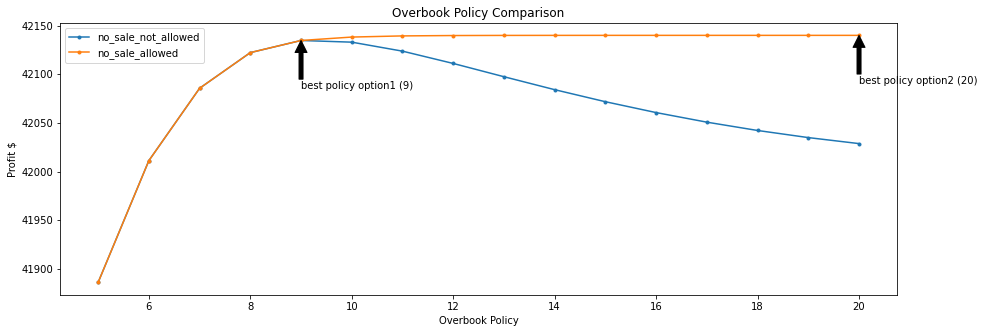

In [39]:
max_p1 = df.profit.max()
max_over1 = df[df.profit == max_p]['overbook']

max_p2 = df.profit_allow_nosale.max()
max_over2 = df[df.profit_allow_nosale == max_p2]['overbook']

plt.figure(figsize=(15,5))
plt.plot(df.overbook, df.profit, marker='.',label='no_sale_not_allowed')
plt.annotate('best policy option1 ({})'.format(int(max_over1)), \
             xy=(max_over1, max_p1), xytext=(max_over1, max_p1-50),\
             arrowprops=dict(facecolor='black'))
plt.plot(df.overbook, df.profit_allow_nosale, marker='.',label='no_sale_allowed')
plt.annotate('best policy option2 ({})'.format(int(max_over2)), \
             xy=(max_over2, max_p2), xytext=(max_over2, max_p2-50),\
             arrowprops=dict(facecolor='black'))
plt.xlabel('Overbook Policy')
plt.ylabel('Profit $')
plt.legend()
plt.title('Overbook Policy Comparison');

Comparing to the original policy (hard cap on sale), this alternative gives a better profit margin when the allowed oversales in the coach class is more than 9. If 9 or more oversales are allowed, the profit made from this second option will be non-decreasing with a very little increase in profit. If oversales are less than 9, then these two strategies are generating the same profit.

## Q4 
Use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of discounted profits? Are there any other interesting questions you can think of? Do this for both policies above.

In [40]:
def price_prob_option1(mode, decision, f_out, c_out): 
    '''
    mode: 1 or 2 (1 if the hard cap strategy; 2 if the alternative)
    decision: 0-4 if mode == 1; 0-6 if mode == 2
    f_out, c_out: boolean (first class sold out, coach class sold out)
    '''
    if mode == 1: # option 1, no sale not allowed
        if (f_out and c_out) or decision == 4: ## both classes sold out
            pc,pf = 0,0
            prc,prf = 0,0
        elif f_out:
            pf,prf = 0,0
            pc = priceHcoach if decision in [0,1] else priceLcoach
            prc = prHc_[0] if decision in [0,1] else prLc_[0]
        elif c_out:
            pc,prc = 0,0
            pf = priceHfirst if decision in [0,2] else priceLfirst
            prf = prHf[0] if decision in [0,2] else prLf[0]
        else:
            if decision == 0:
                pc,pf = priceHcoach,priceHfirst
                prc,prf = prHc[0],prHf[0]
            elif decision == 1:
                pc,pf = priceHcoach,priceLfirst
                prc,prf = prHc[0],prLf[0]
            elif decision == 2:
                pc,pf = priceLcoach,priceHfirst
                prc,prf = prLc[0],prHf[0]
            elif decision == 3:
                pc,pf = priceLcoach,priceLfirst
                prc,prf = prLc[0],prLf[0]
    else: # option 2
        # 0-HH, 1-HL, 2-LH, 3-LL, 4-XH, 5-XL, 6-XX
        if (f_out and c_out) or decision == 6:
            pc,pf = 0,0
            prc,prf = 0,0
        elif f_out:
            pf,prf = 0,0
            if decision in [0,1]: # HH or HL
                pc,prc = priceHcoach,prHc_[0]
            elif decision in [2,3]: # LH or LL
                pc,prc = priceLcoach,prLc_[0]
            else:
                pc,prc = 0,0
        elif c_out:
            pc,prc = 0,0
            pf = priceHfirst if decision in [0,2] else priceLfirst
            prf = prHf[0] if decision in [0,2] else prLf[0]
        else:
            if decision == 0:
                pc,pf = priceHcoach,priceHfirst
                prc,prf = prHc[0],prHf[0]
            elif decision == 1:
                pc,pf = priceHcoach,priceLfirst
                prc,prf = prHc[0],prLf[0]
            elif decision == 2:
                pc,pf = priceLcoach,priceHfirst
                prc,prf = prLc[0],prHf[0]
            elif decision == 3:
                pc,pf = priceLcoach,priceLfirst
                prc,prf = prLc[0],prLf[0]
            elif decision == 4:
                pc,pf = 0,priceLfirst
                prc,prf = 0,prHf[0]
            elif decision == 5:
                pc,pf = 0,priceLfirst
                prc,prf = 0,prLf[0]
    return pc,pf,prc,prf

In [41]:
def get_decision(mode,overbook):
    ## given an option index and oversales allowed, return the decision array U
    if mode == 1: # first option
        _,U = dynamic(overbook)
    else:
        _,U = dynamic_allow_nosale(overbook)
    return U

In [67]:
def simulation(U,over,mode):    
    ## a single time simulation given:
    ### the decision variable array U, 
    ### allowed oversale 'over', and
    ### the option index 'mode'
    
    c,f = 0,0  # first day, no sale
    profit_vec = np.zeros(tN)
    daily_profit_vec = np.zeros(tN)
    tickets_sold = np.zeros((tN,2))
    profit = 0
    
    for t in range(tN):
        decision = int(U[c,f,t])  # decision on sales at time t
        pc,pf,prc,prf = price_prob_option1(mode, decision, f==first, c==coach+over)  
        # extract prices and probability of sale

        sale_c = (np.random.random(1) < prc)  # simulate if the sales are made in each class
        sale_f = (np.random.random(1) < prf)

        daily_profit = sale_c*pc*delta**(t-1) + sale_f*pf*delta**(t-1) # daily profit discounted back to t=0
        profit += daily_profit  # aggregated profit
        
        c += int(sale_c) # update number of tickets being sold
        f += int(sale_f)
        
        tickets_sold[t,:] = [c,f]
        profit_vec[t] = profit
        daily_profit_vec[t] = daily_profit
    
    coach_sold = tickets_sold[:,0]
    first_sold = tickets_sold[:,1]
    
    # last day, need to subtract the cost
    kicked_out = 0
    overbooked = coach_sold[-1]-coach  # number of oversold tickets
    
    ## simulate how many passengers in each class show up
    coach_show = binom.rvs(int(coach_sold[-1]), p_coachshow)
    first_show = binom.rvs(int(first_sold[-1]), p_firstshow)
    first_left = first - first_show
    ## number of passengers need to upgrade to first class
    ## (if passengers show up for coach is less than avaiable seats in coach class, no need to upgrade anyone)
    need_upgrade = coach_show - coach if (coach_show - coach) > 0 else 0
    
    ## all extra coach class passengers can be bumped to first class
    if need_upgrade <= first_left:
        overbooking_cost = bump_first * need_upgrade
    ## not enough seats in first class for all extra coach passengers. We have to bump some of them off plane
    else:
        kicked_out = need_upgrade-first_left
        overbooking_cost = bump_first * first_left + bump_off * kicked_out
    
    ## last day actual profit
    profit_vec[-1] -= overbooking_cost
    
    res = {'coach_sold_vec':coach_sold, 'first_sold_vec':first_sold,\
           'profit_vec':profit_vec, 'daily_profit':daily_profit_vec,\
           'overbooked':overbooked, 'overbook_cost':overbooking_cost,\
           'kicked':kicked_out\
          }
    return res

In [68]:
def plot_ticket_sold(mode,res,over):
    c = res['coach_sold_vec']
    f = res['first_sold_vec']
    plt.figure(figsize=(15,4))
    plt.plot(tValues, c, label='coach class sold')
    plt.plot(tValues, f, label='first class sold')
    plt.hlines(y=coach+over, linestyle='dashed', xmin=0, xmax=T, alpha=0.4, label='overbook')
    plt.hlines(y=coach, linestyle='dotted', xmin=0, xmax=T, alpha=0.4)
    plt.hlines(y=first, linestyle='dashdot', xmin=0, xmax=T, alpha=0.4)
    plt.xlabel('days');
    plt.ylabel('tickets sold')
    if mode == 1:
        plt.title('tickets sold, allow {} overbooks, no sale not allowed'.format(over))
    else:
        plt.title('tickets sold, allow {} overbooks, no sale allowed'.format(over))
    plt.legend(loc='center left');
    
def plot_profit(mode,res):
    fig, ax1 = plt.subplots(figsize=(15,4))
    
    ax2 = ax1.twinx()
    ax1.plot(tValues,res['profit_vec'])
    ax2.bar(tValues,res['daily_profit'],alpha=0.4,color='g')

    ax1.set_xlabel('days')
    ax1.set_ylabel('profit $')
    ax2.set_ylabel('daily profit $')

    if mode == 1:
        ax1.set_title('profits, no sale not allowed');
    else:
        ax1.set_title('profits, no sale allowed');

In [69]:
sim_ob = 5
sim_option = 1

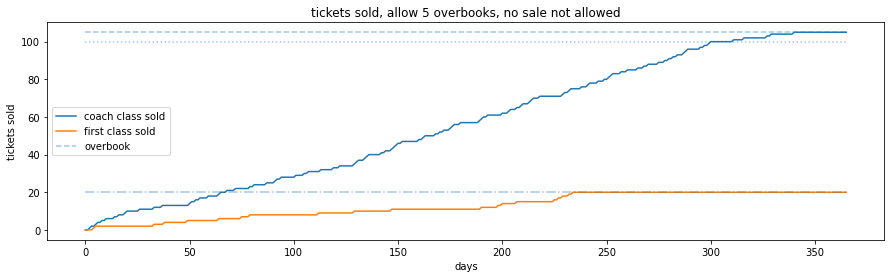

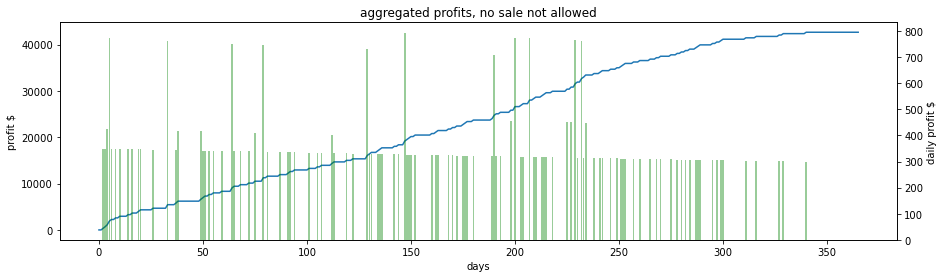

In [70]:
u = get_decision(sim_option,sim_ob)
res = simulation(u,sim_ob,sim_option)
plot_ticket_sold(sim_option,res,sim_ob)
plot_profit(sim_option,res)

In [71]:
sim_ob = 5
sim_option = 2

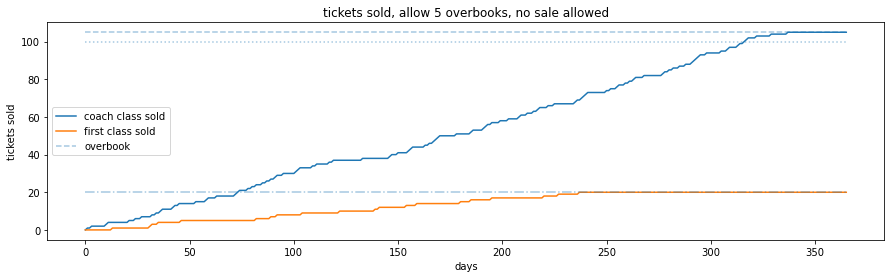

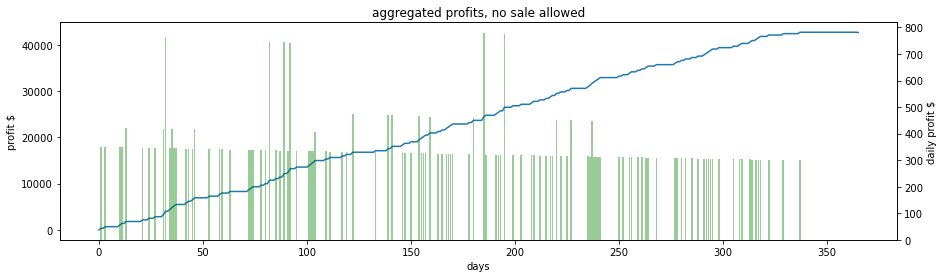

In [72]:
u = get_decision(sim_option,sim_ob)
res = simulation(u,sim_ob,sim_option)
plot_ticket_sold(sim_option,res,sim_ob)
plot_profit(sim_option,res)

In [73]:
def main_simulation(nsim,u,ob,mode):
    # simulate a particular policy 'nsim' times
    
    overbook_bool_vec = np.zeros(nsim)
    overbook_vec = np.zeros(nsim)
    kickout_vec = np.zeros(nsim)
    cost_vec = np.zeros(nsim)
    revenue_vec = np.zeros(nsim)

    for i in range(nsim):
        res = simulation(u,ob,mode) # single simulation result
        profit = res['profit_vec'][-1]
        over, kick, cost = res['overbooked'], res['kicked'], res['overbook_cost']
        if over > 0: # if on the last day, overbooked tickets > 0, then mark it as being 'overbooked'
        # the 'overbook_bool_vec' array contains Boolean value on whether a simulation is in fact overbooked
            overbook_bool_vec[i] = 1
        overbook_vec[i] = over
        kickout_vec[i] = kick
        cost_vec[i] = cost
        revenue_vec[i] = profit
    sim_res = {'overbooked?':overbook_bool_vec, 'overbook_count':overbook_vec, \
               'kickout_count':kickout_vec, 'profit':revenue_vec, 'cost':cost_vec}
    return sim_res

In [80]:
df_dict = {'option':[],'policy':[],'overbooked?':[],\
           'overbook_mean':[], 'kicked_out_mean':[], \
           'profit_avg':[], 'profit_std':[], 'cost_avg':[]}

In [81]:
nsim = 1000
for decision in [1,2]:
    for ob in range(5,21):
        df_dict['option'].append(decision)
        df_dict['policy'].append(ob)

        u = get_decision(decision,ob)
        result = main_simulation(nsim,u,ob,decision)
        df_dict['overbooked?'].append(result['overbooked?'].mean())
        df_dict['overbook_mean'].append(result['overbook_count'].mean())
        df_dict['kicked_out_mean'].append(result['kickout_count'].mean())
        df_dict['profit_avg'].append(result['profit'].mean())
        df_dict['profit_std'].append(result['profit'].std())
        df_dict['cost_avg'].append(result['cost'].mean())
        
        print('opt {}, ob {} done.'.format(decision,ob))

opt 1, ob 5 done.
opt 1, ob 6 done.
opt 1, ob 7 done.
opt 1, ob 8 done.
opt 1, ob 9 done.
opt 1, ob 10 done.
opt 1, ob 11 done.
opt 1, ob 12 done.
opt 1, ob 13 done.
opt 1, ob 14 done.
opt 1, ob 15 done.
opt 1, ob 16 done.
opt 1, ob 17 done.
opt 1, ob 18 done.
opt 1, ob 19 done.
opt 1, ob 20 done.
opt 2, ob 5 done.
opt 2, ob 6 done.
opt 2, ob 7 done.
opt 2, ob 8 done.
opt 2, ob 9 done.
opt 2, ob 10 done.
opt 2, ob 11 done.
opt 2, ob 12 done.
opt 2, ob 13 done.
opt 2, ob 14 done.
opt 2, ob 15 done.
opt 2, ob 16 done.
opt 2, ob 17 done.
opt 2, ob 18 done.
opt 2, ob 19 done.
opt 2, ob 20 done.


In [83]:
db = pd.DataFrame.from_dict(df_dict)
db

,option,policy,overbooked?,overbook_mean,kicked_out_mean,profit_avg,profit_std,cost_avg
0,1,5,1.0,4.965,0.453,41876.340720,724.892296,206.375
1,1,6,1.0,5.941,0.850,41977.468645,812.898707,377.950
2,1,7,1.0,6.831,1.297,42057.022722,902.713460,577.425
3,1,8,1.0,7.662,1.810,42035.101032,982.050299,802.150
4,1,9,1.0,8.289,2.404,41945.701859,1006.208786,1058.400
5,1,10,1.0,8.984,2.801,41990.484373,1043.983585,1233.125
6,1,11,1.0,9.343,3.142,41892.874464,1086.121505,1383.450
7,1,12,1.0,9.927,3.598,41907.021039,1040.580269,1579.150
8,1,13,1.0,10.144,3.698,41853.845072,1025.911431,1625.100
9,1,14,1.0,10.482,3.954,41882.981637,1038.123359,1735.000
